# Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandahouse

from scipy import stats
from random import sample

# Connect to server database

In [18]:
# connect = {'host':'https://clickhouse.lab.karpov.courses',
#            'password':'dpo_python_2020',
#            'user':'student',
#            'database':'simulator_20240120'}

# query = """select exp_group,
#                   user_id,
#                   sum(action = 'view') as views,
#                   sum(action = 'like') as likes,
#                   round(likes * 100/views, 2) as ctr
#             from simulator_20240120.feed_actions
#             where (toDate(time) >= '2023-12-29' and toDate(time) <= '2024-01-04') and exp_group in(1,2)
#             group by exp_group, user_id"""

# df = pandahouse.read_clickhouse(query, connection=connect)

# #save frame
# df.to_csv('data/AB_test.csv', index=False)

In [20]:
df = pd.read_csv('data/AB_test.csv')
df.head(3)

,exp_group,user_id,views,likes,ctr
0,1,109963,15,3,20.00
1,1,26117,141,32,22.70
2,1,138232,73,18,24.66


# А/B - test (from 2023-12-29 to 2024-01-04)

# Choice of the right method

1 - control, 2 - treatment

<Axes: xlabel='ctr', ylabel='Count'>

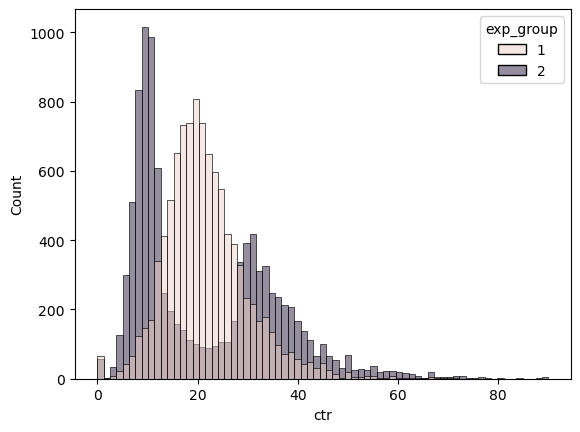

In [21]:
# ctr distribution by groups
sns.histplot(data=df, x='ctr', hue='exp_group')

In [5]:
# T-test
stats.ttest_ind(df[df['exp_group'] == 1]['ctr'], 
                df[df['exp_group'] == 2]['ctr'], 
                equal_var=False)

# Н0 is correct - It's False, that test doesn't fit

Ttest_indResult(statistic=0.40563574434378585, pvalue=0.6850157499538603)

In [22]:
# Mann-Whitney test
print(stats.mannwhitneyu(df[df['exp_group'] == 1]['ctr'], 
                         df[df['exp_group'] == 2]['ctr']))

# 10 000 samples
A_В = 0
for i in range(10000):
    A_В += df[df['exp_group'] == 1]['ctr'].sample().values[0] > df[df['exp_group'] == 2]['ctr'].sample().values[0]
    
print('At', A_В/100, '% verifications random value from 1 sample highest than value from 2 sampe')

# Н0 is correct - True

MannwhitneyuResult(statistic=55189914.5, pvalue=4.6319608004761584e-45)
At 55.36 % verifications random value from 1 sample highest than value from 2 sampe


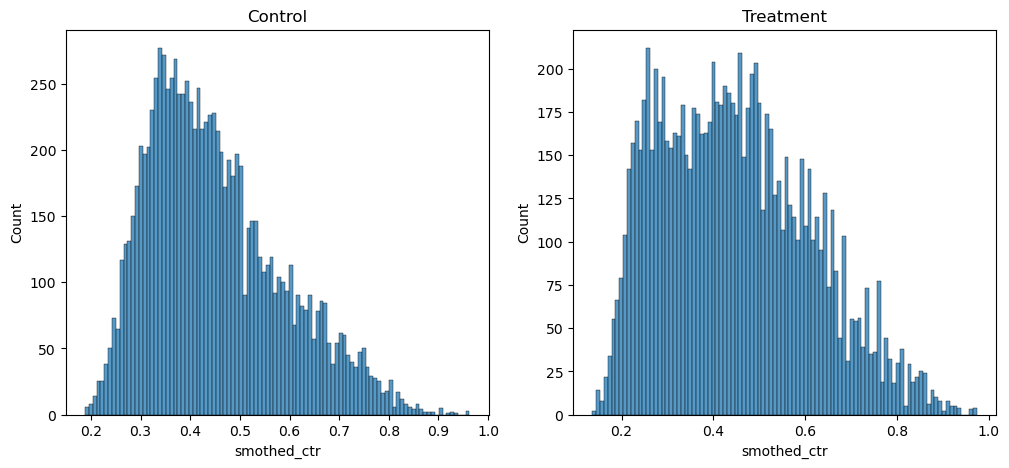

Ttest_indResult(statistic=0.9741402364967034, pvalue=0.3299992460675173)

In [23]:
# T-test smoothed ctr

#function for smooth CTR (users which has a little views)
    # alpha = 20, it can help to smooth the bimodality
    
def get_smothed_ctr(likes, views, global_ctr, alpha):
    smothed_ctr = (likes + alpha + global_ctr) / (views + alpha)
    return smothed_ctr

gl_ctr_1 = df[df['exp_group'] == 1]['likes'].sum()/df[df['exp_group'] == 1]['views'].sum()
gl_ctr_2 = df[df['exp_group'] == 2]['likes'].sum()/df[df['exp_group'] == 2]['views'].sum()


df_sm1 = df[df['exp_group'] == 1].copy()
df_sm1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], gl_ctr_1, 20),
                                 axis=1)

df_sm2 = df[df['exp_group'] == 2].copy()
df_sm2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], gl_ctr_2, 20),
                                 axis=1)

#how much the global averages different in 2 groups?
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

sns.histplot(data=df_sm1['smothed_ctr'], ax=ax[0], bins=100)
sns.histplot(data=df_sm2['smothed_ctr'], ax=ax[1], bins=100)

ax[0].set_title('Control')
ax[1].set_title('Treatment')
plt.show()

# T-test
stats.ttest_ind(df_sm1['smothed_ctr'], 
                df_sm2['smothed_ctr'], 
                equal_var=False)

# Н0 is correct - It's False, that test doesn't fit

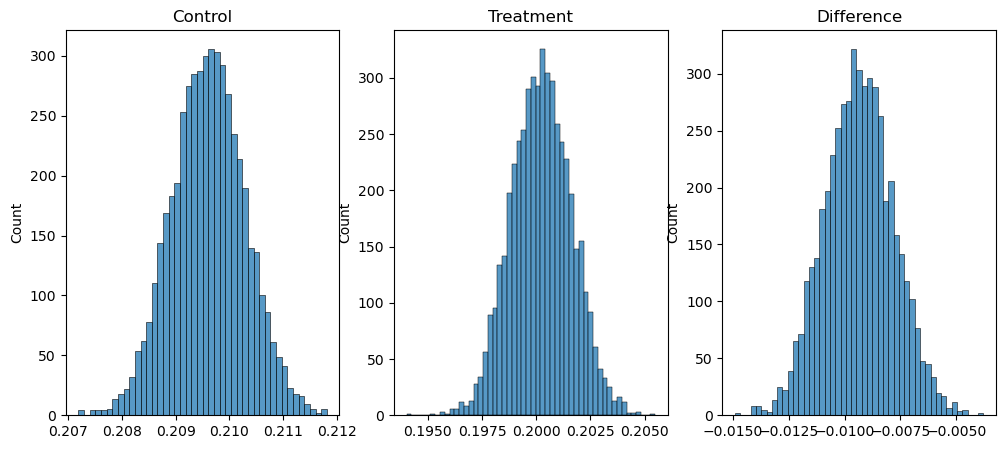

In [24]:
# Poisson bootstrap

# function for mini samples generation
def bootstrap(like1, view1, like2, view2, 
              n_bootstrap=5000): #how many times will generate mini samples
    
    #have random sample from groups А / B; if haven't any value in - weight = 0, if value repeated - weight more than
    pb1 = stats.poisson(1).rvs((5000, len(like1))).astype(np.int64)
    pb2 = stats.poisson(1).rvs((5000, len(like2))).astype(np.int64)
    
    #count global ctr in group by counting every ctrs
    glob_ctr1 = (pb1*like1).sum(axis=1)/(pb1*view1).sum(axis=1)
    glob_ctr2 = (pb2*like2).sum(axis=1)/(pb2*view2).sum(axis=1)
    
    return glob_ctr1, glob_ctr2


# global views and likes in groups
like1 = df[df['exp_group'] == 1]['likes'].to_numpy()
view1 = df[df['exp_group'] == 1]['views'].to_numpy()
like2 = df[df['exp_group'] == 2]['likes'].to_numpy()
view2 = df[df['exp_group'] == 2]['views'].to_numpy()

# ctr counting
ctr1, ctr2 = bootstrap(like1, view1, like2, view2)

#how much the global averages different in 2 groups?
fig, ax = plt.subplots(ncols=3, figsize=(12, 5))

sns.histplot(data=ctr1, ax=ax[0])
sns.histplot(data=ctr2, ax=ax[1])
sns.histplot(data=(ctr2 - ctr1), ax=ax[2])      #intersection of quantiles

ax[0].set_title('Control')
ax[1].set_title('Treatment')
ax[2].set_title('Difference')
plt.show()

#difference histogram does NOT cross 0 => groups are different (in control group avg. ctr highest)

MannwhitneyuResult(statistic=190.0, pvalue=2.6199245185137612e-05)
Ttest_indResult(statistic=6.687159945040673, pvalue=2.631069969301057e-06)


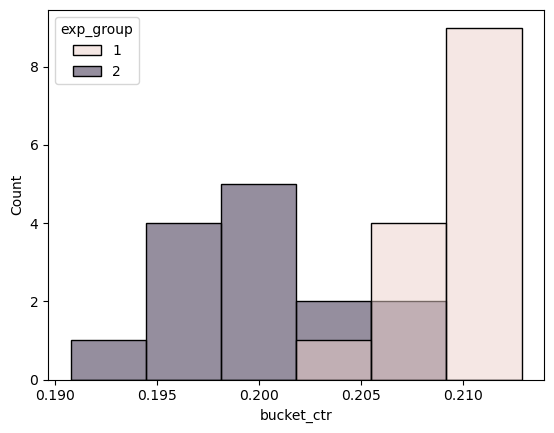

In [26]:
# Bucket Conversion Method

# to share А and В groups by 19897 / 700 = 28 subgroups (each by 14)
# query = """select exp_group, bucket,
#                   sum(likes)/sum(views) as bucket_ctr
#             from(select exp_group, 
#                         xxHash64(user_id)%14 as bucket,
#                           user_id, 
#                           sum(action = 'view') as views, 
#                           sum(action = 'like') as likes, 
#                           round(likes * 100/views,2) as ctr
#                     from simulator_20240120.feed_actions
#                     where (toDate(time) >= '2023-12-29' and toDate(time) <= '2024-01-04') and exp_group in(1,2)
#                     group by exp_group, bucket, user_id)
#             group by exp_group, bucket"""
# dfB = pandahouse.read_clickhouse(query, connection=connect)

#save frame
# dfB.to_csv('AB_test_bucket_12.csv', index=False)

#load
dfB = pd.read_csv('data/AB_test_bucket_12.csv')


# distribution of ctr by groups
sns.histplot(data=dfB, x='bucket_ctr', hue='exp_group')

#to compare average ctr between bucket groups
print(stats.mannwhitneyu(dfB[dfB['exp_group'] == 1]['bucket_ctr'],
                         dfB[dfB['exp_group'] == 2]['bucket_ctr']))

print(stats.ttest_ind(dfB[dfB['exp_group'] == 1]['bucket_ctr'],
                      dfB[dfB['exp_group'] == 2]['bucket_ctr'],
                      equal_var=False))

# Both tests show that average ctrs in groups have statistically difference

# Bucket Method

In [29]:
# load frame groups 0 and 3

# query = """select exp_group,
#                   user_id,
#                   sum(action = 'view') as views,
#                   sum(action = 'like') as likes,
#                   round(likes * 100/views, 2) as ctr
#             from simulator_20240120.feed_actions
#             where (toDate(time) >= '2023-12-29' and toDate(time) <= '2024-01-04') and exp_group in(0,3)
#             group by exp_group, user_id"""

# df1 = pandahouse.read_clickhouse(query, connection=connect)

# #save frame
# df1.to_csv('AB_test_bucket_03.csv', index=False)

#load
df1 = pd.read_csv('data/AB_test_bucket_03.csv')

## Analysis

<Axes: xlabel='ctr', ylabel='Count'>

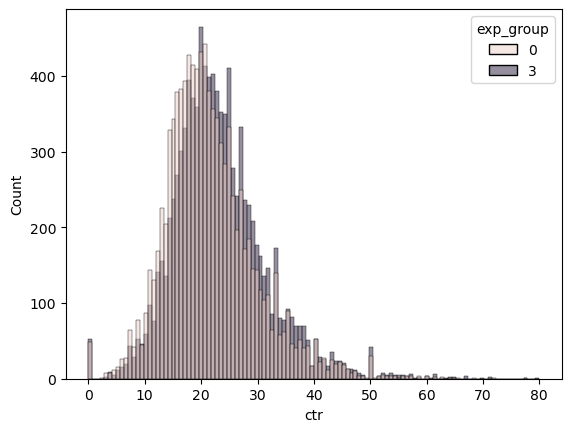

In [30]:
# distribution between 0 and 3
sns.histplot(data=df1, x='ctr', hue='exp_group')

<Axes: xlabel='ctr', ylabel='Count'>

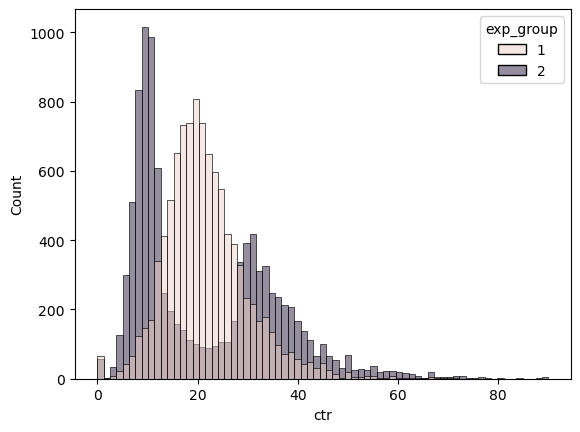

In [31]:
# distribution between 1 and 2
sns.histplot(data=df, x='ctr', hue='exp_group')

In [34]:
df2 = df.copy()

# to count general CTR in control groups
ctr_control1 = sum(df1[df1['exp_group'] == 0]['likes'])/sum(df1[df1['exp_group'] == 0]['views'])
ctr_control2 = sum(df2[df2['exp_group'] == 1]['likes'])/sum(df2[df2['exp_group'] == 1]['views'])

# to count individual ctr by users in both campaigns
df1['linearized_likes'] = df1.apply(lambda x: x['likes'] - ctr_control1*x['views'], axis=1)
df2['linearized_likes'] = df.apply(lambda x: x['likes'] - ctr_control2*x['views'], axis=1)

# to compare t-test in both campaigns by linearized metric (likes)
print('Campaign_1:', stats.ttest_ind(df1[df1['exp_group'] == 0]['linearized_likes'], 
                                     df1[df1['exp_group'] == 3]['linearized_likes'], 
                                     equal_var=False))

print('Campaign_2:', stats.ttest_ind(df2[df2['exp_group'] == 1]['linearized_likes'], 
                                     df2[df2['exp_group'] == 2]['linearized_likes'], 
                                     equal_var=False))

# The both campaigns have statistically difference

Campaign_1: Ttest_indResult(statistic=-16.186230032932844, pvalue=1.4918137745326139e-58)
Campaign_2: Ttest_indResult(statistic=5.93637710193448, pvalue=2.9805064038668164e-09)


<Axes: xlabel='linearized_likes', ylabel='Count'>

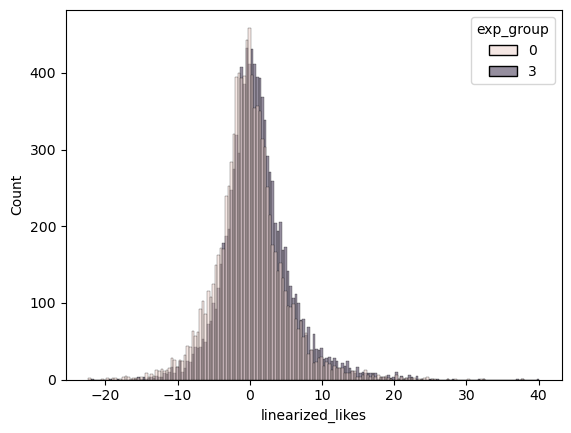

In [35]:
# linearized distribution between 0 and 3
sns.histplot(data=df1, x='linearized_likes', hue='exp_group')

<Axes: xlabel='linearized_likes', ylabel='Count'>

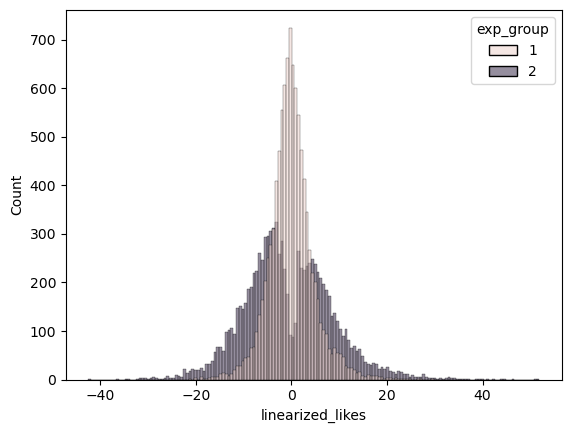

In [36]:
# linearized distribution between 1 and 2
sns.histplot(data=df2, x='linearized_likes', hue='exp_group')

In [37]:
# t-test ctr in Campaign №1
print('Campaign_1:', stats.ttest_ind(df1[df1['exp_group'] == 0]['ctr'], 
                                     df1[df1['exp_group'] == 3]['ctr'], 
                                     equal_var=False))

# t-test ctr in Campaign №2 (Bucket method)
print('Campaign_2:', stats.ttest_ind(dfB[dfB['exp_group'] == 1]['bucket_ctr'],
                      dfB[dfB['exp_group'] == 2]['bucket_ctr'],
                      equal_var=False))

Campaign_1: Ttest_indResult(statistic=-13.935197776853277, pvalue=6.226638965644041e-44)
Campaign_2: Ttest_indResult(statistic=6.687159945040673, pvalue=2.631069969301057e-06)
